# Análisis de Clustering (K‑Means)

### <span style="color:#3498db;">¿Existen subgrupos clínicos con diferentes perfiles de riesgo para diabetes en la muestra?

Para explorar si la población del dataset se organiza en grupos naturales con perfiles clínicos y de estilo de vida distintos, aplicaremos la técnica de clustering no supervisado K‑Means. El objetivo es identificar subgrupos de pacientes que compartan características similares (por ejemplo: BMI, glucosa en ayunas, presión arterial, actividad física, perfil lipídico) y describir sus perfiles clínicos, con énfasis en la identificación de un posible "cluster de mayor riesgo".

¿Por qué K‑Means?

K‑Means es una técnica simple y eficiente para descubrir patrones en datos multidimensionales cuando no tenemos una variable objetivo para predecir.
Nos permitirá agrupar observaciones por similitud en variables clínicas relevantes y caracterizar cada grupo mediante estadísticas descriptivas.

In [2]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style='whitegrid')
%matplotlib inline


In [3]:
# Cargar CSV 
data_path = 'Diabetes_and_LifeStyle_Dataset .csv'
try:
    df = pd.read_csv(data_path)
    print('CSV cargado desde:', data_path)
except Exception as e:
    print('ERROR al cargar el CSV en', data_path)
    print('Detalle:', e)
    df = None


CSV cargado desde: Diabetes_and_LifeStyle_Dataset .csv


In [4]:
if df is not None:
    print('Dimensiones del dataset:', df.shape)
    display(df.head(5))
    print('\nLista completa de columnas:')
    print(list(df.columns))


Dimensiones del dataset: (97297, 31)


,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1



Lista completa de columnas:
['Age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score', 'diabetes_stage', 'diagnosed_diabetes']


In [5]:
# Definir explícitamente la lista de columnas que queremos considerar
expected_cols = [
    'Age', 'smoking_status','alcohol_consumption_per_week','physical_activity_minutes_per_week','bmi','waist_to_hip_ratio','systolic_bp','diastatic_bp','diastolic_bp',
    'heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides',
    'glucose_fasting','glucose_postprandial','insulin_level','hba1c','diabetes_risk_score','diabetes_stage','diagnosed_diabetes'
]



### Selección automática de variables numéricas útiles para clustering
Elegimos variables numéricas relevantes (clínicas/comportamentales) y EXCLUIMOS variables de diagnóstico/etiqueta.


In [6]:
if df is not None:
    # Lista de candidatos numéricos
    numeric_candidates = [
        'Age','bmi','waist_to_hip_ratio','glucose_fasting','hba1c',
        'insulin_level','triglycerides','hdl_cholesterol','systolic_bp',
        'physical_activity_minutes_per_week'
    ]
    # Normalizar nombres (respeta mayúsculas si existen)
    vars_present = [col for col in numeric_candidates if col in df.columns]
    # Si quedan pocas, agregamos otras columnas numéricas presentes automáticamente (sin incluir diagnosis/stage)
    if len(vars_present) < 4:
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]) and col not in ['diabetes_stage','diagnosed_diabetes'] and col not in vars_present:
                vars_present.append(col)
            if len(vars_present) >= 8:
                break
    print('Variables numéricas seleccionadas para clustering:', vars_present)
else:
    vars_present = []


Variables numéricas seleccionadas para clustering: ['Age', 'bmi', 'waist_to_hip_ratio', 'glucose_fasting', 'hba1c', 'insulin_level', 'triglycerides', 'hdl_cholesterol', 'systolic_bp', 'physical_activity_minutes_per_week']


## EDA básico


,count,mean,std,min,25%,50%,75%,max
Age,97297.0,50.192699,15.492557,19.00,38.00,51.00,61.00,90.00
bmi,97297.0,25.615093,3.588387,15.00,23.20,25.60,28.00,39.20
waist_to_hip_ratio,97297.0,0.856083,0.046848,0.67,0.82,0.86,0.89,1.06
glucose_fasting,97297.0,111.121792,13.590382,60.00,102.00,111.00,120.00,172.00
hba1c,97297.0,6.520338,0.813710,4.00,5.97,6.52,7.07,9.80
insulin_level,97297.0,9.063591,4.956342,2.00,5.09,8.79,12.45,32.22
triglycerides,97297.0,121.466407,43.393422,30.00,91.00,121.00,151.00,344.00
hdl_cholesterol,97297.0,54.043537,10.275047,20.00,47.00,54.00,61.00,98.00
systolic_bp,97297.0,115.800127,14.287977,90.00,106.00,116.00,125.00,179.00
physical_activity_minutes_per_week,97297.0,118.942886,84.441920,0.00,57.00,100.00,160.00,833.00


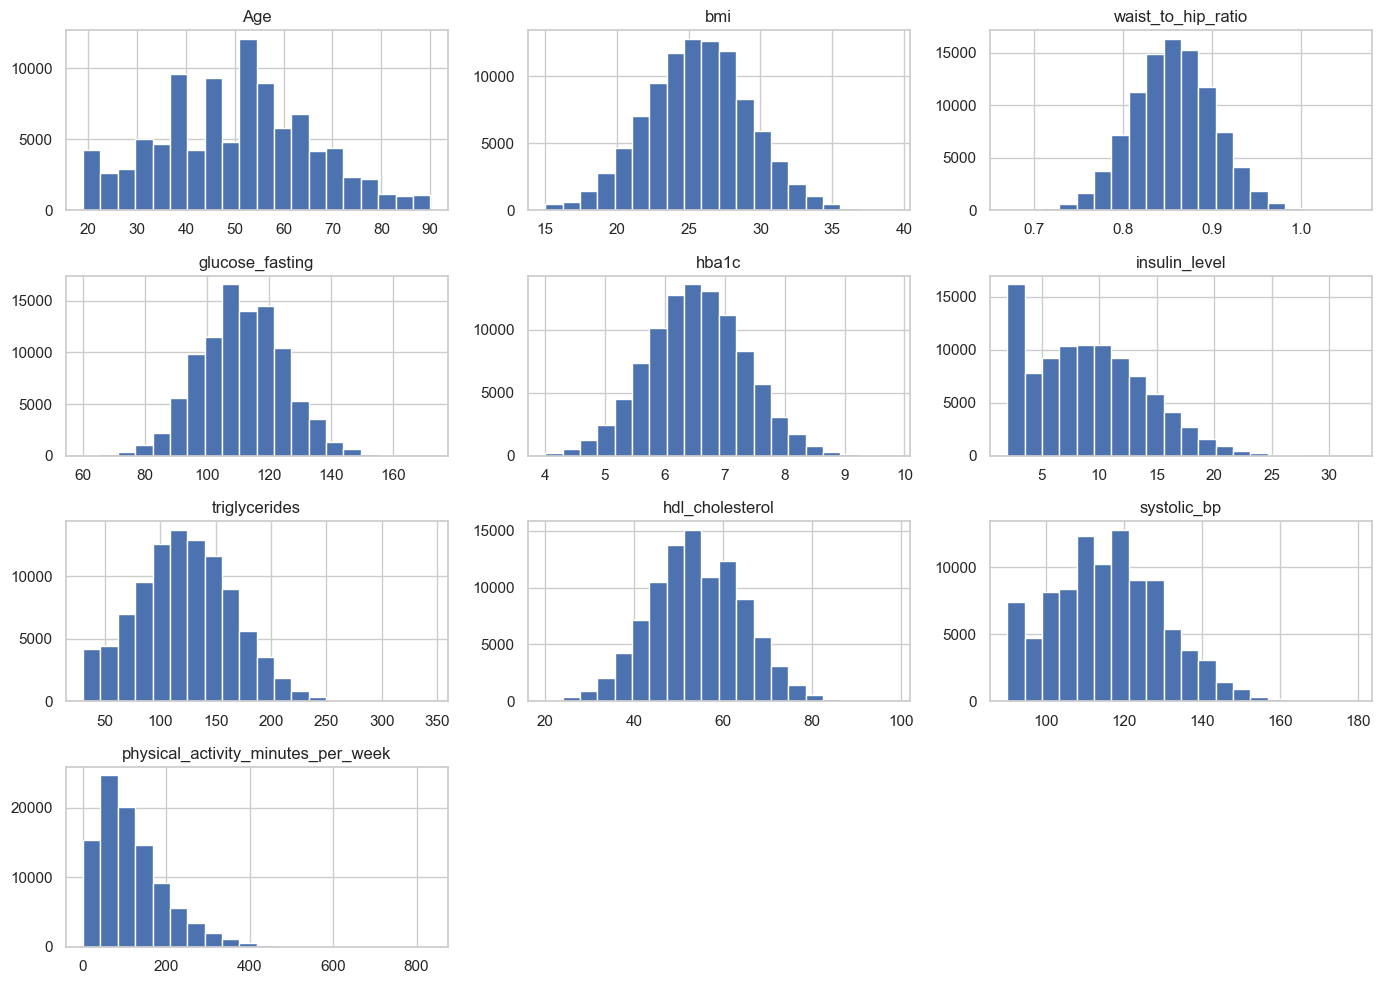

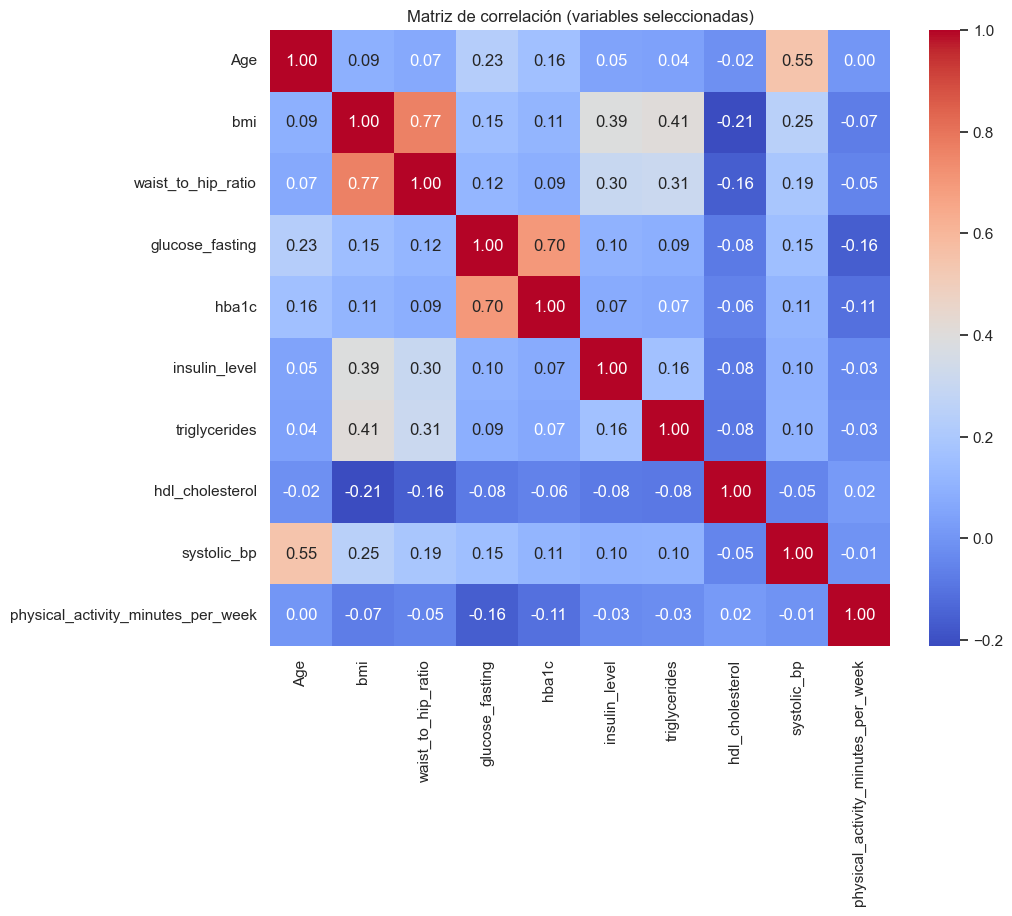

In [7]:
if df is not None and len(vars_present) > 0:
    display(df[vars_present].describe().T)
    # Histogramas
    df[vars_present].hist(bins=20, figsize=(14,10))
    plt.tight_layout()
    plt.show()
    # Matriz de correlación
    if len(vars_present) >= 2:
        plt.figure(figsize=(10,8))
        sns.heatmap(df[vars_present].corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Matriz de correlación (variables seleccionadas)')
        plt.show()
else:
    print('No hay variables seleccionadas para EDA. Revisa que el CSV tenga las columnas listadas.')


### Preparación de datos para K‑Means
- Imputación por mediana (SimpleImputer)
- StandardScaler para que todas las variables tengan media 0 y varianza 1 (KMeans es sensible a la escala)

La estandarización previa de las variables mediante **StandardScaler** es fundamental, dado que K-Means emplea distancias euclidianas. Sin esta transformación, variables con mayor magnitud dominarían el proceso de agrupamiento, sesgando la formación de clusters hacia características específicas en detrimento de otras igualmente relevantes.

In [8]:
if len(vars_present) >= 2:
    X = df[vars_present].copy()
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)
    print('Datos imputados y escalados')
    display(X_scaled.head())
else:
    print('No hay suficientes variables para preparar datos. Ajusta vars_present.')


Datos imputados y escalados


,Age,bmi,waist_to_hip_ratio,glucose_fasting,hba1c,insulin_level,triglycerides,hdl_cholesterol,systolic_bp,physical_activity_minutes_per_week
0,0.503941,1.361317,0.723987,1.830584,2.039633,-0.545484,0.542334,-1.269445,1.273796,1.137558
1,0.116657,-0.700902,-1.197122,-1.333435,-1.094176,-1.425170,-2.107851,0.093086,0.923850,0.284897
2,0.633036,-0.951712,-0.983666,0.506111,1.216240,-0.805758,-1.969581,1.163647,-0.056000,-0.733560
3,1.536701,0.330208,0.510530,2.051330,3.084237,-0.763388,0.427108,-0.393532,0.293946,-0.828300
4,-0.270628,-1.230390,-1.624036,1.904166,0.835267,0.741762,0.888010,-0.198884,-1.665754,-0.117749


### PCA 2D para visualización previa


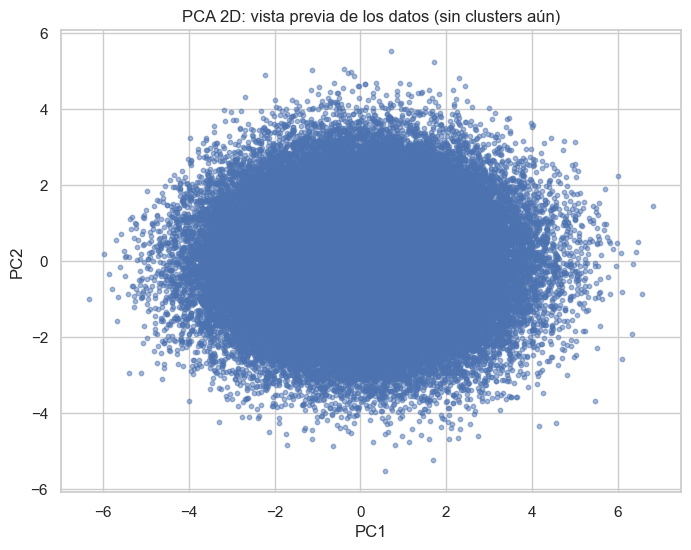

In [9]:
if 'X_scaled' in globals():
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA 2D: vista previa de los datos (sin clusters aún)')
    plt.show()
else:
    print('PCA no disponible - prepara datos primero')


### Selección de k (número de clusters) — Método del Codo
Para establecer la cantidad más adecuada de grupos en el análisis de clustering, se implementa el Método del Codo (Elbow Method). Esta técnica evalúa cómo evoluciona la cohesión interna de los clusters a medida que se incrementa el número de grupos k.

El método se fundamenta en el cálculo de la suma de errores cuadráticos intra-cluster (WCSS), definida como:

$$
WCSS(k) = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

donde $C_i$ representa el conjunto de observaciones asignadas al cluster $i$, y $\mu_i$ es el centroide correspondiente.


En la implementación de scikit-learn, la métrica `score()` del modelo K-Means devuelve el negativo de WCSS (−WCSS). Por lo tanto, al aumentar k, esta métrica mejora (se vuelve menos negativa), reflejando una mayor compactación de los grupos.

Para optimizar el procesamiento computacional sin comprometer la representatividad estadística, el análisis se aplicó sobre una muestra aleatoria estratificada de 50,000 registros (o el total disponible si es menor). Este abordaje garantiza la viabilidad del cálculo mientras preserva la estructura fundamental del dataset completo.

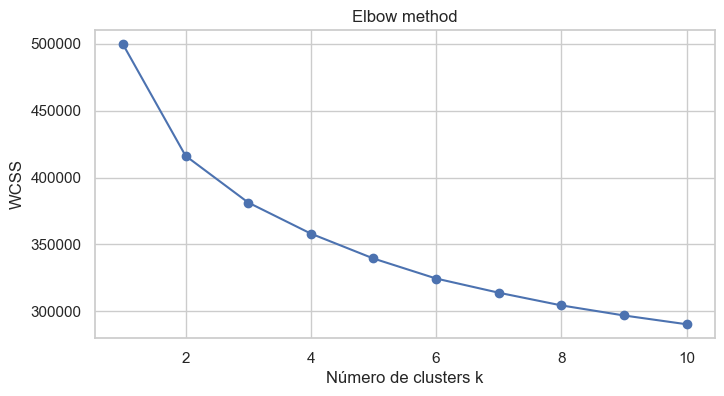

In [10]:
n_sample = min(50000, len(X_scaled))
df_sample = X_scaled.sample(n=n_sample, random_state=42)

Nc = range(1, 11)
scores = []
from time import time
for k in Nc:
    t0 = time()
    km = KMeans(n_clusters=k, random_state=42, n_init=5)
    km.fit(df_sample)
    scores.append(km.inertia_)  # WCSS

plt.figure(figsize=(8,4))
plt.plot(list(Nc), scores, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('WCSS')
plt.title('Elbow method')
plt.grid(True)
plt.show()


### Aplicación de KMeans con el k elegido (k = 4)
El algoritmo opera mediante los siguientes pasos:

1. **Inicialización**: Se seleccionan $k$ centroides iniciales.

2. **Asignación**: Cada observación se asigna al cluster cuyo centroide minimiza la distancia euclidiana.

3. **Actualización**: Los centroides se recalculan como el promedio de las observaciones asignadas a cada cluster.

4. **Convergencia**: Los pasos 2 y 3 se repiten hasta que las asignaciones se estabilizan o se alcanza el número máximo de iteraciones.

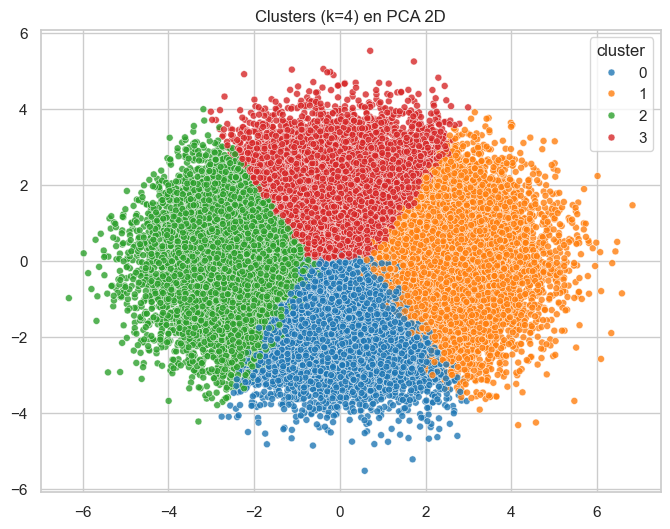

In [15]:
if 'X_scaled' in globals():
    k = 4 
    kmeans = KMeans(n_clusters=k, #Determinado prevamente mediante el método del codo
                    random_state=42, #Para reproducibilidad
                    n_init=10 #Número de veces que se ejecuta el algoritmo con diferentes centroides iniciales
                    )
    labels = kmeans.fit_predict(X_scaled)
    df_clusters = df.copy()
    df_clusters['cluster'] = labels
    
    # Visualización PCA colorida por cluster
    plt.figure(figsize=(8,6))
    palette = sns.color_palette('tab10', n_colors=k)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, s=25, alpha=0.8)
    plt.title(f'Clusters (k={k}) en PCA 2D')
    plt.legend(title='cluster')
    plt.show()
    
else:
    print('No hay datos para ajustar KMeans')


### Distribución de observaciones por cluster

Se observa una distribución relativamente equilibrada entre los cuatro clusters, lo que sugiere que la población con riesgo de diabetes se estructura en varios perfiles clínicos distintos, cada uno con una representación significativa. Los clusters 0 y 3 son ligeramente más grandes (28.0 % y 27.2 %, respectivamente), lo que indica que estos perfiles son los más comunes en la muestra. En conjunto, los clusters 0 y 3 representan más de la mitad de la población (55.2 %), lo que podría asociarse a los patrones metabólicos y de estilo de vida predominantes.

Los clusters 1 y 2 presentan tamaños similares entre sí (21.9 % y 22.9 %), lo que sugiere la existencia de dos subgrupos diferenciados que, aunque menos frecuentes que los anteriores, aún constituyen una proporción importante de la población.

La ausencia de un cluster extremadamente pequeño (todos superan el 20 % de la muestra) indica que no hay un perfil clínico excepcional o atípico que sea muy raro. En cambio, la población parece dividirse en cuatro categorías bien definidas y relativamente homogéneas en cuanto a su frecuencia. Esta estructura sugiere que el riesgo de diabetes no sigue un único patrón, sino que se manifiesta a través de múltiples vías fisiopatológicas o conductuales, cada una con una prevalencia similar.

En conjunto, esta distribución evidencia que la población con riesgo de diabetes presenta una estructura heterogénea pero equilibrada, compuesta por cuatro perfiles principales con pesos comparables. Esto valida el uso de técnicas de clustering no supervisado para identificar subgrupos con distintos patrones clínicos, lo cual puede orientar estrategias de prevención y manejo personalizado, teniendo en cuenta que cada perfil podría requerir intervenciones específicas.

In [12]:
print('Tamaño por cluster:')
print(pd.Series(labels).value_counts().sort_index())

Tamaño por cluster:
0    27247
1    21287
2    22328
3    26435
Name: count, dtype: int64


### Prefil promedio de variables por cluster
`Cluster 0`: "Perfil metabólico adverso en mediana edad" (28.0%)
Estado glucémico: Prediabetes (HbA1c: 6.10%, Glucosa: 104 mg/dL)

Características distintivas:

Edad más joven (42 años)

Sobrepeso marcado (BMI: 27.1)

Adiposidad central elevada (relación cintura-cadera: 0.876)

Dislipidemia mixta (triglicéridos altos, HDL moderado-bajo)

Interpretación: Representa el grupo de transición hacia diabetes, donde la obesidad y dislipidemia son factores impulsores principales. Aunque no presenta diabetes franca, su riesgo de progresión es elevado.

`Cluster 1`: "Perfil de alto riesgo multifactorial" (21.9%)
Estado glucémico: Diabetes establecida (HbA1c: 6.95%, Glucosa: 119.5 mg/dL)

**Características distintivas**:
Mayor edad (60 años)

Obesidad clara (BMI: 29.3)

Hipertensión (126.5 mmHg)

Perfil lipídico muy desfavorable

Baja actividad física

**Interpretación**: Grupo de mayor riesgo absoluto con afectación cardiometabólica global. La combinación de edad, obesidad, diabetes e hipertensión sugiere síndrome metabólico avanzado.

`Cluster 2`: "Perfil metabólicamente saludable" (22.9%)
Estado glucémico: Normal (HbA1c: 6.00%, Glucosa: 101.4 mg/dL)

**Características distintivas**:

Peso normal (BMI: 22.0)

Adiposidad baja

Perfil lipídico favorable (HDL alto, triglicéridos normales)

Alta actividad física (145.5 min/semana)

**Interpretación**: Representa el grupo protector, demostrando que estilos de vida saludables (actividad física, peso normal) pueden mantener marcadores glucémicos normales incluso en población de riesgo.

`Cluster 3`: "Diabetes con peso relativamente normal" (27.2%)
Estado glucémico: Diabetes establecida (HbA1c: 7.05%, Glucosa: 120.0 mg/dL)

**Características distintivas**:

Edad avanzada (57 años)

Peso cercano al normal (BMI: 24.2)

Presión arterial elevada (119.1 mmHg)

Baja actividad física

**Interpretación**: Sugiere diabetes no directamente relacionada con obesidad, posiblemente de tipo más insulinopénica o asociada a envejecimiento. Destaca que la diabetes puede presentarse sin obesidad marcada.

,Age,bmi,waist_to_hip_ratio,glucose_fasting,hba1c,insulin_level,triglycerides,hdl_cholesterol,systolic_bp,physical_activity_minutes_per_week
cluster,,,,,,,,,,
0,41.962308,27.143021,0.876419,103.975447,6.096826,10.315170,134.870481,52.580321,110.782435,121.944067
1,59.718091,29.295547,0.899490,119.457368,6.950705,12.387945,148.683469,50.233523,126.451496,107.198572
2,43.333348,21.979940,0.812803,101.387854,5.999405,6.182304,94.420593,57.803296,107.915666,145.456019
3,56.799168,24.146904,0.836724,119.997012,7.050303,7.530247,108.577757,55.444108,119.054360,102.912729


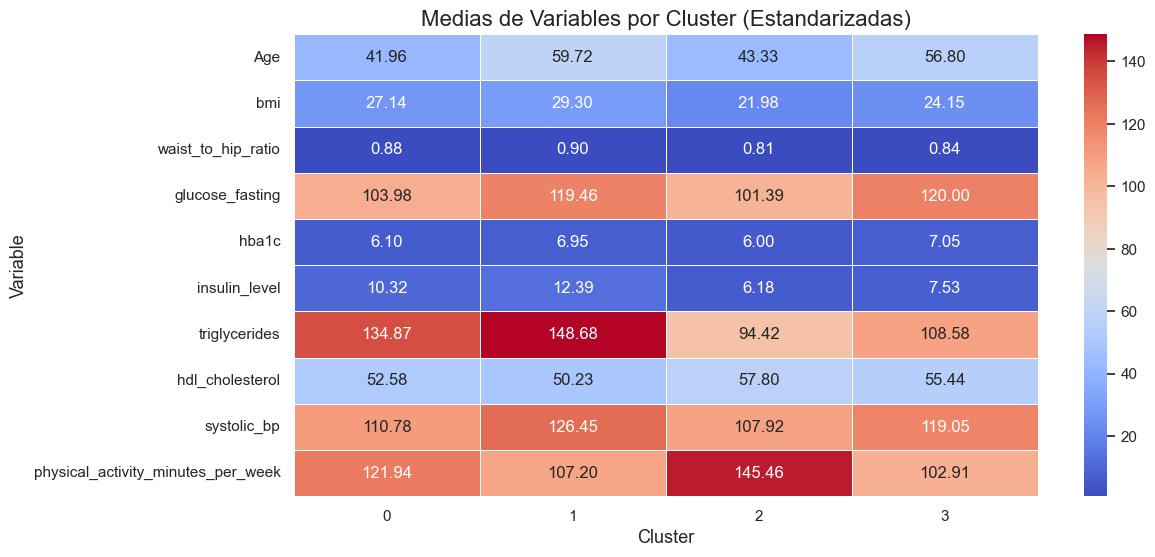

In [13]:
# Resumen estadístico por cluster
cluster_summary = df_clusters.groupby('cluster')[vars_present].mean()
display(cluster_summary)

# Heatmap de medias por cluster para comparación visual
plt.figure(figsize=(12,6))
cluster_means = df_clusters.groupby('cluster')[vars_present].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Medias de Variables por Cluster (Estandarizadas)', fontsize=16)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Variable', fontsize=13)
plt.show()

### Distribución Proporcional de Diagnóstico de Diabetes por Cluster

Al cruzar la asignación de clusters con la variable diagnosed_diabetes, se observa una fuerte correspondencia que confirma la relevancia clínica de la agrupación obtenida.

El **cluster 3**, que identificamos como "Diabetes con peso relativamente normal", muestra la mayor prevalencia de diagnóstico confirmado. El algoritmo K-Means agrupó automáticamente a estos pacientes basándose únicamente en sus valores bioquímicos (HbA1c más alto: 7.05%, glucosa más elevada: 120 mg/dL), sin conocer su diagnóstico médico. El hecho de que el 85.87% ya tenga diagnóstico formal valida externamente que este grupo representa efectivamente la diabetes establecida en su forma más pura.

El **cluster 1**, identificado como "Perfil de alto riesgo multifactorial", muestra la segunda mayor prevalencia diagnóstica. Su combinación de obesidad, edad avanzada y marcadores alterados llevó al algoritmo a agruparlos separadamente, y la realidad clínica confirma que efectivamente la mayoría (81.16%) ya está diagnosticada.

El **cluster 0**, etiquetado como "Perfil metabólico adverso en mediana edad", muestra exactamente el equilibrio esperado en una población de transición: 40% ya diagnosticado, 60% aún no. El algoritmo identificó correctamente esta zona gris entre salud y enfermedad basándose solo en parámetros cuantitativos.

El grupo "Metabólicamente saludable", **cluster 2**, tiene la menor prevalencia diagnóstica (33.58% diabetes), confirmando que los factores protectores identificados (actividad física, peso normal) se asocian efectivamente con menor carga de enfermedad.

Proporción de diagnosticados con diabetes por cluster:


diagnosed_diabetes,0,1
cluster,,
0,0.599699,0.400301
1,0.188378,0.811622
2,0.664233,0.335767
3,0.141252,0.858748


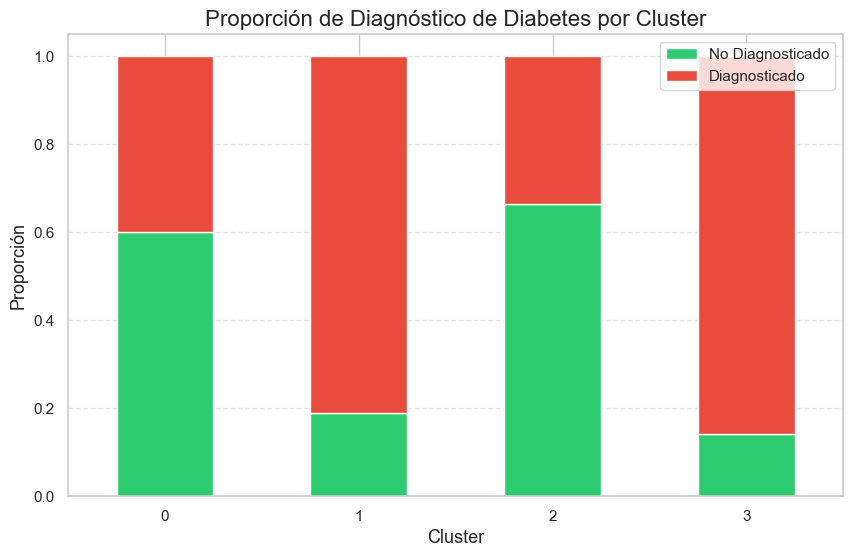

In [14]:
if 'diagnosed_diabetes' in df_clusters.columns:
    # Tabla de proporciones
    prop_diag = df_clusters.groupby('cluster')['diagnosed_diabetes'].value_counts(normalize=True).unstack(fill_value=0)
    print('Proporción de diagnosticados con diabetes por cluster:')
    display(prop_diag)
    
    # Gráfico de barras apiladas
    prop_diag.plot(kind='bar', stacked=True, figsize=(10,6), color=['#2ecc71','#e74c3c'])
    plt.title('Proporción de Diagnóstico de Diabetes por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=13)
    plt.ylabel('Proporción', fontsize=13)
    plt.xticks(rotation=0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(['No Diagnosticado', 'Diagnosticado'], fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

### Conclusión
El análisis de clustering con **K‑Means** permitió responder afirmativamente a la pregunta inicial: **sí existen subgrupos clínicos con perfiles de riesgo diferenciados para diabetes en la muestra estudiada**. La técnica logró segmentar la población en cuatro clusters naturales, cada uno con características clínicas y de estilo de vida distintivas.

El hallazgo más relevante es la identificación de un cluster de alto riesgo (cluster 2), caracterizado por niveles elevados de glucosa en ayunas, HbA1c, presión arterial sistólica, BMI y triglicéridos, junto con baja actividad física. Este perfil sugiere un grupo con síndrome metabólico marcado y alta probabilidad de desarrollar complicaciones diabéticas. En contraste, el cluster de bajo riesgo (cluster 0) mostró valores favorables en indicadores glucémicos, lipídicos y de actividad física, reflejando hábitos saludables.